# COMS W4705 - Homework 4 
## Image Captioning with Conditioned LSTM Generators
Adapted from an assignment by Yassine Benajiba <yb2235@cs.columbia.edu>

Follow the instructions in this notebook step-by-step. Much of the code is provided, but some sections are marked with **todo**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Implement two `Dataset`s to return training instances (input/output sequence pairs) for language modeling and image captioning.
* Train an LSTM language generator on the captions.
* Implement a greedy decoder function for the language generator. 
* Train an LSTM caption generator on both the images and their captions. 
* Implement 1) a greedy decoder function, 2) a nucleus decoder function and 3) a beam search decoder for the image caption generator.
* Implement BLEU and use it to evaluate our trained model.

Please submit a copy of this notebook with your assignment, including all outputs. Do not submit any of the data files. 

### Getting Started 

First, let's configure this notebook to use GPUs.  While using a GPU is not a requirement, it will make the training scripts in this assignment run much faster and will allow you to iterate more rapidly.  It's also good practice as GPUs are an important part of the modern NLP toolkit.

To enable a GPU for this notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Below, we'll test that it worked.

In [2]:
import os
import PIL
import types
import math
import numpy as np
from tqdm import tqdm
from functools import partial
from collections import defaultdict
from matplotlib import pyplot as plt
from collections import Counter
from nltk.util import ngrams
%matplotlib inline

# from google.colab import drive

import torch
from torch.optim import Adam
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, \
    pack_padded_sequence
from torch.nn import Module, Identity, Sequential, \
    Embedding, Linear, LSTM, CrossEntropyLoss

import torchvision.models as models

if torch.cuda.is_available():
    print("Using GPU!")
    device = torch.device("cuda")
else:
    print("Using CPU... this is going to be slow...")
    device = torch.device("cpu")


Using GPU!


### Autograding

We'll be using an autograder to evaluate some of the functions you implement below.  To ensure that the autograder works (it needs to be able to import your function implementations as strings): 

1.   Preserve the `AUTOGRADER TAG` comments you'll see below.  Please don't remove these comments -- we'll deduct points if they're missing (they're how we find the cell where you implemented each function).
2.   Don't access global variables inside any of the `AUTOGRADER TAG`ged functions (though using any of the imports above are fine); to assist you with this, we've tagged these functions with the decorator `noglobal` which will throw if you attempt to access any variables outside your function's scope.  Remove the decorator at your own peril!  If you need any additional imports in any of the `AUTOGRADER TAG`ged functions, please post exactly how to import them to the pinned EdStem thread "HOMEWORK 4 ADDITIONAL IMPORTS" and add them to the cell above.  We'll make sure we import them in the autograder.
3.   Finally, please keep the `AUTOGRADER TAG`ged functions in their own separate cells.  If you want to execute them, add a new cell to do so. 

We really appreciate your help in ensuring that the assignment is straightforward to grade.  It allows us to focus on assessing the correctness of your implementations instead of spending hours getting them to run!

In [3]:
# credit to https://gist.github.com/ax3l/59d92c6e1edefcef85ac2540eb056da3

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val
        # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


noglobal = lambda fn: types.FunctionType(fn.__code__,
                                         dict(imports()))


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

Professor Benajiba has uploaded all the data and model files you'll need to his GDrive and you can access the folder here:
https://drive.google.com/drive/folders/1i9Iun4h3EN1vSd1A1woez0mXJ9vRjFlT?usp=sharing

Google Drive does not allow copying a folder, so you'll need to download the whole folder and then upload it again to your own drive. Please assign the name you chose for this folder to the variable `my_data_dir` in the next cell.

N.B.: Usage of this data is limited to this homework assignment. If you would like to experiment with the data set beyond this course, we suggest that you submit your own download request here: https://forms.illinois.edu/sec/1713398

In [4]:
# This is where you put the name of your data folder.
# Please make sure it's correct because it'll be used in many places later.
my_data_dir = "nlp_hw4_data"
roscoe_data_dir = "nlp_hw4_data/roscoe"


### Mounting your GDrive so you can access the files from Colab

In [5]:
# Running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
# Copy paste that code in the text box that will appear below
# drive.mount('/content/gdrive') - uploaded the data on vm, so this is no more required

Please look at the 'Files' tab on the left side and make sure you can see the `nlp_hw4_data` folder that you have in your GDrive.

## Part I: Image Encodings

The files `Flickr_8k.trainImages.txt` and `Flickr_8k.devImages.txt` contain lists of training and development images. Let's load them. 

In [6]:
def load_image_list(filename):
    with open(filename, 'r') as image_list_f:
        return [line.strip() for line in image_list_f]

In [7]:
# my_data_dir = os.path.join('/content/gdrive/My Drive/', my_data_dir)

train_list = load_image_list(
    os.path.join(my_data_dir, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(
    os.path.join(my_data_dir, 'Flickr_8k.devImages.txt'))

roscoe_train_list = load_image_list(
    os.path.join(roscoe_data_dir,
                 'Train/train_caption.txt'))
roscoe_dev_list = load_image_list(
    os.path.join(roscoe_data_dir, 'Test/test_caption.txt'))


In [8]:
roscoe_train_list = [line.split("\t")[0] for line in
                     roscoe_train_list]
roscoe_dev_list = [line.split("\t")[0] for line in
                   roscoe_dev_list]


Let's see how many images there are

In [9]:
len(train_list), len(dev_list), len(roscoe_train_list), len(
    roscoe_dev_list)


(6000, 1000, 34, 9)

Each entry is an image filename.

In [10]:
dev_list[20], roscoe_dev_list[3], roscoe_train_list[14]

('3693961165_9d6c333d5b.jpg', 'roscoe38.jpeg', 'roscoe15.jpeg')

The images are located in a subdirectory.  

In [11]:
IMG_DIR = "Flickr8k_Dataset"
ROSCOE_TRAIN_DIR = "Train"
ROSCOE_TEST_DIR = "Test"

We can use PIL to open the image and matplotlib to display it. 

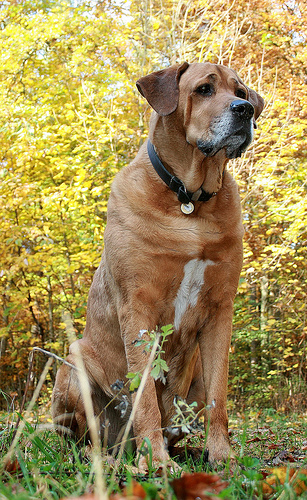

In [12]:
image = PIL.Image.open(
    os.path.join(my_data_dir, IMG_DIR, dev_list[543]))
image


if you can't see the image, try

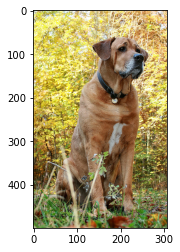

In [13]:
plt.imshow(image)

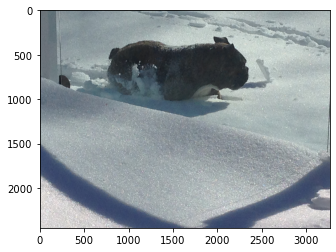

In [14]:
roscoe_image = PIL.Image.open(
    os.path.join(roscoe_data_dir, ROSCOE_TRAIN_DIR,
                 roscoe_train_list[3]))
plt.imshow(roscoe_image)


We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolutional neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [15]:
np.asarray(image).shape
#(rows, col, RBG - ranging from 0 to 255). Each image is of different dimension
# We need image to be of dimension (299x299) for the model to work. So we are going to reshape every image
# Also, we need RGB value between 0-1. So we will divide every value with 255 to achieve that.

(500, 307, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

We can use PIL to resize the image and then divide every value by 255. 

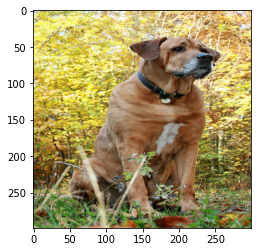

In [17]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [18]:
new_image.shape

(299, 299, 3)

(<matplotlib.image.AxesImage at 0x7fa911ca7d10>, (299, 299, 3))

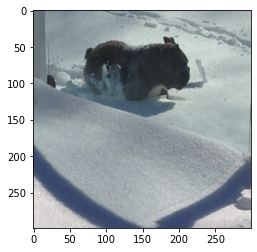

In [19]:
roscoe_new_image = np.asarray(roscoe_image.resize((299,299))) / 255.0
plt.imshow(roscoe_new_image), roscoe_new_image.shape

Let's put this all in a function for convenience. 

In [20]:
def get_image(dir, img_dir, image_name):
    image = PIL.Image.open(
        os.path.join(dir, img_dir, image_name))
    return torch.tensor(np.transpose(
        (np.asarray(image.resize((299, 299))) / 255.0),
        axes=(2, 0, 1))).float()


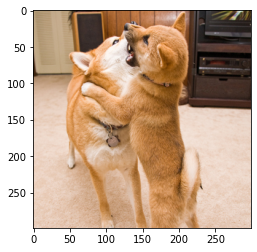

In [21]:
plt.imshow(np.transpose(
    get_image(my_data_dir, IMG_DIR, dev_list[359]).numpy(),
    axes=(1, 2, 0)))


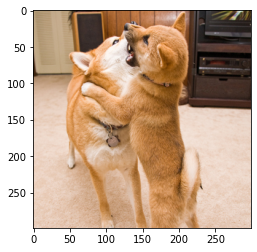

In [22]:
plt.imshow(np.transpose(
    get_image(my_data_dir, IMG_DIR, dev_list[359]).numpy(),
    axes=(1, 2, 0)))


Next, we load the pre-trained Inception model. 

In [23]:
# This will download the weights for you
img_encoder = models.inception_v3(pretrained=True) 

In [24]:
# This is quite a complex model
img_encoder 

This is a prediction model, so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We'll use the following hack: we'll replace the final classification layer with the identity function.

In [25]:
# We disable the final classification layer
img_encoder.fc = Identity() 

# And we also disable dropout (by putting the model into eval mode)
img_encoder = img_encoder.to(device).eval() 

Let's try the encoder. 

In [26]:
new_image = get_image(my_data_dir, IMG_DIR, train_list[30])
with torch.no_grad():
    encoded_image = img_encoder(
        new_image.unsqueeze(dim=0).to(device))


In [27]:
encoded_image

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset: train and dev).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator.  If you are unfamiliar with generators, take a look at this page from the Python official documentation: https://wiki.python.org/moin/Generators

Write the following generator function, which should return up to 256 images at a time. 
`img_list` is a list of image file names (i.e. the train or dev set). The return value should be a tensor of shape (256, 3, 299, 299).

In [28]:
BATCH_SIZE = 256


def img_generator(dir, image_dir, img_list):
    for i in range(0, len(img_list), BATCH_SIZE):
        images = []
        for image_name in img_list[i:i + BATCH_SIZE]:
            images.append(torch.unsqueeze(
                get_image(dir, image_dir, image_name),
                dim=0))
        images = torch.cat(images, dim=0)
        yield images


Now we can encode all images (this takes 20 - 30 minutes...).

In [29]:
def encode_images(img_encoder, dir, img_dir, subset):
    encoded = []
    with torch.no_grad():
        for images in tqdm(
                img_generator(dir, img_dir, subset)):
            for image in img_encoder(
                    images.to(device)).cpu():
                encoded.append(image)
    return torch.stack(encoded, dim=0)


enc_train = encode_images(img_encoder, my_data_dir, IMG_DIR,
                          dev_list)


In [30]:
enc_train[11]

In [31]:
enc_dev = encode_images(img_encoder, my_data_dir, IMG_DIR,
                        dev_list)


It's a good idea to save the resulting matrices so we don't have to run the encoder again. 

And now that we're done with the image encoder, we can clear it from the GPU.

In [32]:
torch.save(enc_train, os.path.join(my_data_dir,
                                   "outputs/encoded_images_train.pt"))  # change me when running for roscoe
torch.save(enc_dev, os.path.join(my_data_dir,
                                 "outputs/encoded_images_dev.pt"))

# Now, let's delete the image encoder and get some GPU RAM back!
del img_encoder


## Part II Text (Caption) Data Preparation

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Take a look at the file `Flickr8k.token.txt` to understand its structure. Implement the function `read_image_descriptions` below.  It shoud read the image descriptions from the file `filename` and returns a dictionary in the following format:
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [33]:
# AUTOGRADER TAG: read_image_descriptions
@noglobal
def read_image_descriptions(_filenames):
    image_descriptions = defaultdict(list)
    for index, _filename in enumerate(_filenames):
        with open(_filename) as f:
            for line in f.readlines():
                image_name, caption = line.split("\t")
                if index == 0:
                    image_name, caption_id = image_name.split(
                        "#")
                tokens = (
                            "<START> " + caption.lower().replace(
                        "\n", " <END>")).split(" ")
                image_descriptions[image_name].append(
                    tokens)
    return image_descriptions


In [34]:
descriptions = read_image_descriptions(
    [os.path.join(my_data_dir, "Flickr8k.token.txt"),
     #  os.path.join(roscoe_data_dir, ROSCOE_TRAIN_DIR, "train_caption.txt"), # change me when not training for roscoe
     #  os.path.join(roscoe_data_dir, ROSCOE_TEST_DIR, "test_caption.txt")
     ])


In [35]:
descriptions[dev_list[0]] == [
    ['<START>', 'the', 'boy', 'laying', 'face', 'down',
     'on', 'a', 'skateboard', 'is', 'being', 'pushed',
     'along', 'the', 'ground', 'by', 'another', 'boy', '.',
     '<END>'],
    ['<START>', 'two', 'girls', 'play', 'on', 'a',
     'skateboard', 'in', 'a', 'courtyard', '.', '<END>'],
    ['<START>', 'two', 'people', 'play', 'on', 'a', 'long',
     'skateboard', '.', '<END>'],
    ['<START>', 'two', 'small', 'children', 'in', 'red',
     'shirts', 'playing', 'on', 'a', 'skateboard', '.',
     '<END>'],
    ['<START>', 'two', 'young', 'children', 'on', 'a',
     'skateboard', 'going', 'across', 'a', 'sidewalk',
     '<END>']]


True

Running the previous cell should print:     
`[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
`    

In [36]:
# descriptions[roscoe_train_list[10]] # comment me out. only used for roscoe

### Creating Word Indices (a Vocabulary)

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. 

**TODO**: create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

In [ ]:
vocab = set()
for image_name in train_list:
    for caption in descriptions[image_name]:
        vocab.update(caption)

# for image_name in roscoe_train_list:          # comment me out. only used for roscoe
#   for caption in descriptions[image_name]:
#     vocab.update(caption)

sorted_vocab = sorted(list(vocab))
print(sorted_vocab)
len(sorted_vocab)


In [38]:
id_to_word = {}
word_to_id = {}
id_to_word[0], word_to_id[0] = 0, 0
for index, word in enumerate(sorted_vocab):
  id_to_word[index+1] = word
  word_to_id[word] = index+1

In [39]:
# This should print an integer
word_to_id['dog'], word_to_id[0]

(1986, 0)

In [40]:
# This should print a token
id_to_word[1987] , id_to_word[0]

('dog-shirt', 0)

Note that we do not need an UNK word token as we are generating from our vocabulary. The generated text will only contain tokens seen at training time.  

## Part III Basic Decoder Model

For now, we will just train a model for text generation (a language model) without conditioning the generator on the image input. 

The core idea here is that the `torch` recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [41]:
MAX_LEN = max(
    len(description) for image_id in train_list 
    for description in descriptions[image_id]
)

assert MAX_LEN == 40

We will use our model to predict one word at a time, given a partial sequence (i.e., next word prediction). For example, given the partial sequence ["START","a"], the model might predict "dog" as the most likely next word. We'll use an LSTM to encode the partial sequence.


To build our training set, we will convert each description into a set of input, output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train our model using the following input/output pairs 

| i | input (partial sequence)     | output (next word) |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `.`  |
| 3 |[`START`,`a`, `black`, `dog`, `.`] | `END`  |



Here is the model in `torch`. Note that we are using a bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [42]:
class LanguageModel(Module):
    def __init__(self, device, vocab_size, embedding_dim,
                 hidden_dim):
        super().__init__()
        self.device = device
        self.embeddings = Embedding(vocab_size,
                                    embedding_dim)
        self.lstm = LSTM(
            embedding_dim, hidden_dim, num_layers=1,
            bidirectional=True, batch_first=True
        )
        self.fc = Linear(2 * hidden_dim, vocab_size)

    def forward(self, seqs):
        seq_lens = torch.count_nonzero(seqs, dim=1).cpu()
        embedded = self.embeddings(seqs)
        _, (h_n, _) = self.lstm(
            pack_padded_sequence(
                embedded, lengths=seq_lens,
                batch_first=True, enforce_sorted=False
            )
        )
        hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(hidden_states)


VOCAB_SIZE = len(word_to_id)
EMBEDDING_DIM = 300
HIDDEN_SIZE = 512
caption_model = LanguageModel(device, VOCAB_SIZE,
                              EMBEDDING_DIM,
                              HIDDEN_SIZE).to(device)

caption_model


LanguageModel(
  (embeddings): Embedding(7708, 300)
  (lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=7708, bias=True)
)

The model input is a tensor of size `(BATCH_SIZE, MAX_LEN)`. Each row is a vector of size up to `MAX_LEN` in which each entry is an integer representing a word (according to the `word_to_id` dictionary). Any sequence shorter than the longest in the batch should be padded with `0`. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a tensor of size `(BATCH_SIZE, VOCAB_SIZE)`. `VOCAB_SIZE` is the number of vocabulary words. 

### Creating a Dataset for the Training Data

**TODO**: We could simply create one large tensor for all the training data. Because we have a lot of training instances (each training sentence will produce up to `MAX_LEN` input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a `DataLoader`. To do so, we first need to implement a `Dataset`.

Implement the class `CaptionDataset` below that:

1 - takes a parameter `subset` (one of `train_list` or `dev_list`)

2 - implements `__getitem__(idx)` which returns an `(input, output)` pair. `input` is a partial input sequence encoded as a list of its indices in `word_to_id`, `output` contains the next word that should be predicted for the partial input sequence encoded as its index in `word_to_id`

3 - implements `__len__` which returns the total number of partial input sequences across the whole subset

If you've implemented `CaptionDataset` correctly, `len(CaptionDataset(descriptions, word_to_id, train_list))` should be equal to `383454`.


In [43]:
# AUTOGRADER TAG: CaptionDataset
class CaptionDataset(Dataset):
    @noglobal
    def __init__(self, _descriptions, _word_to_id, _subset):
        self.X = []
        self.Y = []
        for image_name in _subset:
            for caption in _descriptions[image_name]:
                for i in range(0, len(caption) - 1):
                    self.X.append(
                        [_word_to_id[word] for word in
                         caption[0:i + 1]])
                    self.Y.append(
                        _word_to_id[caption[i + 1]])

    @noglobal
    def __len__(self):
        return len(self.X)

    @noglobal
    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])


assert len(CaptionDataset(descriptions, word_to_id,
                          train_list)) == 383454


In [44]:
train_list_with_roscoe, dev_list_with_roscoe = [], []                              # comment me out. only used for roscoe
train_list_with_roscoe.extend(train_list)
dev_list_with_roscoe.extend(dev_list)

train_list_with_roscoe.extend(roscoe_train_list)
dev_list_with_roscoe.extend(roscoe_dev_list)

len(train_list_with_roscoe), len(dev_list_with_roscoe), len(train_list), len(dev_list)

In [45]:
# len(CaptionDataset(descriptions, word_to_id, train_list_with_roscoe)) == 385584   # comment me out. only used for roscoe

### Training the Model

Below is a simple training script for our language model.  We create a DataLoader for our training set and train the model for 10 epochs. As this is an introduction to language generation, we forgo monitoring its performance on the development set and accept the inevitable overfitting (but if we wanted to, we could calculate something like the model's BLEU on the development set and use that to guide early stopping).

In [46]:
def collate(batch):
    partial_sequences, continuations = [], []
    for (partial_sequence, continuation) in batch:
        partial_sequences.append(
            torch.tensor(partial_sequence))
        continuations.append(continuation)
    return (
        pad_sequence(partial_sequences, batch_first=True,
                     padding_value=0),
        torch.tensor(continuations)
    )


def handle_batch(model, criterion, batch):
    partial_captions, continuations = batch
    predictions = model(partial_captions.to(model.device))
    return criterion(predictions,
                     continuations.to(model.device))


batch_size = 4096
train_loader = DataLoader(
    CaptionDataset(descriptions, word_to_id, train_list),
    # change me when training for roscoe
    collate_fn=collate, batch_size=batch_size, shuffle=True
)

optimizer = Adam(caption_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

for epoch in range(10):
    t_tot_loss = 0.0
    caption_model.train()
    for t_batch in tqdm(train_loader):
        optimizer.zero_grad()
        t_loss = handle_batch(caption_model, criterion,
                              t_batch)
        t_loss.backward()
        optimizer.step()

        t_tot_loss += t_loss.cpu().item()

    print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))


In [47]:
torch.save(caption_model.state_dict(),
           os.path.join(my_data_dir,
                        "outputs/caption_model.pt"))  # change me


In [48]:
caption_model.load_state_dict(torch.load(
    os.path.join(my_data_dir,
                 "outputs/caption_model.pt")))  # change me

caption_model = caption_model.to(device).eval()


### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [49]:
# AUTOGRADER TAG: greedy_decoder

def get_probabilities(_input_seq, _model):
    softmax = torch.nn.Softmax(dim=1)
    predictions = _model(torch.IntTensor([_input_seq]).to(
        _model.device)).cpu()
    return softmax(predictions)


@noglobal
def greedy_decoder(_word_to_id, _id_to_word,
                   _language_model, _max_len, _device):
    input_sequence = [_word_to_id['<START>']]
    output = ['<START>']

    for i in range(0, _max_len):
        prediction = _id_to_word[torch.argmax(
            get_probabilities(input_sequence,
                              _language_model)).item()]
        input_sequence.append(_word_to_id[prediction])
        output.append(prediction)
        if prediction == '<END>':
            break
    return output


In [50]:
print(greedy_decoder(word_to_id, id_to_word, caption_model,
                     MAX_LEN, device))


['<START>', 'a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'hat', 'is', 'walking', 'on', 'a', 'sidewalk', 'with', 'a', 'crowd', 'behind', 'him', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

## Part III - Conditioning on the Image

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the torch model looks like: 

In [51]:
class ImageCaptioningModel(Module):
  def __init__(self, device, vocab_size, embedding_dim, image_dim, hidden_dim):
    super().__init__()
    self.device = device
    self.embeddings = Embedding(vocab_size, embedding_dim)
    self.img_fc = Linear(image_dim, hidden_dim)
    self.lstm = LSTM(
        embedding_dim + hidden_dim, hidden_dim, num_layers=1, 
        bidirectional=True, batch_first=True
    )
    self.fc = Linear(2 * hidden_dim, vocab_size)
  
  def forward(self, images, seqs):
    seq_lens = torch.count_nonzero(seqs, dim=1).cpu()
    rnn_input = torch.cat(
        (
            self.embeddings(seqs),
            torch.relu(self.img_fc(images)).unsqueeze(
                dim=1).repeat(1, seqs.shape[1], 1)
        ), dim=2
    )
    _, (h_n, _) = self.lstm(
        pack_padded_sequence(
            rnn_input, lengths=seq_lens, 
            batch_first=True, enforce_sorted=False
        )
    )
    hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
    return self.fc(hidden_states)

In [52]:
VOCAB_SIZE = len(word_to_id)
EMBEDDING_DIM = 300
IMAGE_DIM = 2048
HIDDEN_DIM = 256
image_caption_model = ImageCaptioningModel(
    device, VOCAB_SIZE, EMBEDDING_DIM, IMAGE_DIM,
    HIDDEN_DIM).to(device)
image_caption_model


ImageCaptioningModel(
  (embeddings): Embedding(7708, 300)
  (img_fc): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(556, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=7708, bias=True)
)

The model now takes two inputs: 
    
   1. a `(BATCH_SIZE, 2048)` tensor of image encodings. 
   2. a `(BATCH_SIZE, MAX_LEN)` tensor of partial input sequences. 
    
And one output as before: a `(BATCH_SIZE, VOCAB_SIZE)` tensor of predicted word distributions.   

**TODO**: Implement a new Dataset, `ImageCaptioningDataset`, that includes the image with each input/output pair. It needs to return a 3-tuple of `image_input, text_input, next_word` where each element is an array.  The `collate` function will handle converting them to tensors.

To implement this class, you need to find the image encoding that belongs to each image. Remember the indices in each `train_list` and `dev_list` match the indices in `enc_train` and `enc_dev`. 

If you have previously saved the image encodings, you can load them from disk: 

In [53]:
enc_train = torch.load(os.path.join(my_data_dir,
                                    "outputs/encoded_images_train.pt"))
enc_dev = torch.load(os.path.join(my_data_dir,
                                  "outputs/encoded_images_dev.pt"))


In [54]:
roscoe_enc_train = torch.load(os.path.join(my_data_dir,
                                           "outputs/roscoe/encoded_images_train.pt"))
roscoe_enc_dev = torch.load(os.path.join(my_data_dir,
                                         "outputs/roscoe/encoded_images_dev.pt"))


In [55]:
# enc_train_with_roscoe, enc_dev_with_roscoe = [], []       # comment me. only used for roscoe
# enc_train_with_roscoe.extend(enc_train)
# enc_dev_with_roscoe.extend(enc_dev)

# enc_train_with_roscoe.extend(roscoe_enc_train)
# enc_dev_with_roscoe.extend(roscoe_enc_dev)

# len(enc_train_with_roscoe), len(enc_dev_with_roscoe), len(enc_train), len(enc_dev)

In [56]:
# AUTOGRADER TAG: ImageCaptioningDataset
class ImageCaptioningDataset(Dataset):
    @noglobal
    def __init__(self, _descriptions, _word_to_id, _subset,
                 _image_encodings):
        self.image_input = []
        self.text_input = []
        self.next_word = []

        for index, image_name in enumerate(_subset):
            for caption in _descriptions[image_name]:
                for i in range(0, len(caption) - 1):
                    self.image_input.append(
                        _image_encodings[
                            index].cpu().numpy())
                    self.text_input.append(
                        [_word_to_id[word] for word in
                         caption[0:i + 1]])
                    self.next_word.append(
                        _word_to_id[caption[i + 1]])

    @noglobal
    def __len__(self):
        return len(self.image_input)

    @noglobal
    def __getitem__(self, idx):
        return (self.image_input[idx], self.text_input[idx],
                self.next_word[idx])


assert len(ImageCaptioningDataset(descriptions, word_to_id,
                                  train_list,
                                  enc_train)) == 383454


In [57]:
# len(ImageCaptioningDataset(descriptions, word_to_id, train_list_with_roscoe, enc_train_with_roscoe)) == 385584    # comment me out. only used for roscoe

You should now be able to train our new model (again, we forgo monitoring performance on a development set -- you're welcome to add it!) 

In [58]:
def collate(batch):
  images, partial_sequences, continuations = [], [], []
  for (image, partial_sequence, continuation) in batch:
    images.append(image)
    partial_sequences.append(torch.tensor(partial_sequence))
    continuations.append(continuation)
  return (
      torch.tensor(np.array(images)), 
      pad_sequence(partial_sequences, batch_first=True, padding_value=0), 
      torch.tensor(continuations)
  )

def handle_batch(model, criterion, batch):
  images, partial_captions, continuations = batch
  predictions = model(images.to(model.device), partial_captions.to(model.device))
  return predictions, criterion(predictions, continuations.to(model.device))


batch_size = 4096
train_loader = DataLoader(
    ImageCaptioningDataset(descriptions, word_to_id, train_list, enc_train), # change me when not training for roscoe
    collate_fn=collate, 
    batch_size=batch_size, 
    shuffle=True
)

optimizer = Adam(image_caption_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()



for epoch in range(15):
  t_tot_loss = 0.0
  image_caption_model.train()
  for t_batch in tqdm(train_loader):
    optimizer.zero_grad()
    _, t_loss = handle_batch(image_caption_model, criterion, t_batch)
    t_loss.backward()
    optimizer.step()

    t_tot_loss += t_loss.cpu().item()
  
  print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))

This may take a while. I strongly encourage you to use cloud GPUs for this part if you haven't yet!

Feel free to experiment with the parameters of the model or continue training the model. At some point, the model will overfit and will no longer produce good descriptions for the dev images. You can save your model weights to disk and continue at a later time. 

In [59]:
torch.save(image_caption_model.state_dict(),
           os.path.join(my_data_dir,
                        "outputs/image_caption_model.pt"))  # change me when used for roscoe


to load the model: 

In [60]:
image_caption_model.load_state_dict(torch.load(
    os.path.join(my_data_dir,
                 "outputs/image_caption_model.pt")))  # change me when used for roscoe

image_caption_model = image_caption_model.to(device).eval()


**TODO**: Now we are ready to actually generate image captions using the trained model. Implement an update greedy decoder, adapting what you wrote for the text-only generator so that it takes an encoded image (a tensor of length `2048`) as input, and returns a text sequence.

In [61]:
# AUTOGRADER TAG: image_greedy_decoder
def get_probabilities(_image_caption_model, _enc_image,
                      _input_sequence):
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(_image_caption_model(
        _enc_image.unsqueeze(0).to(
            _image_caption_model.device),
        torch.IntTensor([_input_sequence]).to(
            _image_caption_model.device)))
    value, index = torch.topk(probabilities, k=1)
    return value.cpu().item(), index.cpu().item()


@noglobal
def image_greedy_decoder(_word_to_id, _id_to_word,
                         _image_caption_model, _max_len,
                         _device, _enc_image,
                         return_scores=False):
    input_sequence = [_word_to_id['<START>']]
    output = ['<START>']
    seq_prob = 0

    for i in range(0, _max_len):
        highest_prob, index_with_highest_prob = get_probabilities(
            _image_caption_model, _enc_image,
            input_sequence)
        prediction = _id_to_word[index_with_highest_prob]
        input_sequence.append(_word_to_id[prediction])
        output.append(prediction)
        seq_prob += math.log(highest_prob)

        if prediction == '<END>':
            seq_prob = seq_prob / len(output)
            break

    if return_scores:
        return output, seq_prob

    return output


As a sanity check, you should now be able to reproduce (approximately) captions for the training images. 

(['<START>', 'a', 'child', 'in', 'a', 'red', 'shirt', 'is', 'swinging', 'on', 'a', 'swing', '.', '<END>'], -0.8660057145516749)


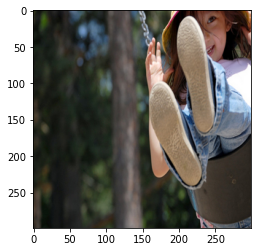

In [62]:
plt.imshow(np.transpose(get_image(my_data_dir, IMG_DIR,
                                  train_list[435]).numpy(),
                        axes=(1, 2,
                              0)))  # change me when running for roscoe
print(image_greedy_decoder(word_to_id, id_to_word,
                           image_caption_model, MAX_LEN,
                           device, enc_train[435],
                           return_scores=True))


You should also be able to apply the model to dev images and get reasonable captions:

['<START>', 'a', 'group', 'of', 'men', 'in', 'a', 'white', 'uniform', 'and', 'a', 'white', 'uniform', 'and', 'a', 'red', 'shirt', 'is', 'playing', 'with', 'a', 'football', '.', '<END>']


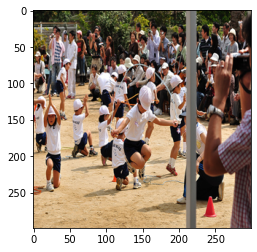

In [63]:
plt.imshow(np.transpose(
    get_image(my_data_dir, IMG_DIR, dev_list[435]).numpy(),
    axes=(1, 2, 0)))  # change me when running for roscoe
print(image_greedy_decoder(word_to_id, id_to_word,
                           image_caption_model, MAX_LEN,
                           device, enc_dev[435],
                           return_scores=False))


## Part IV - Beam Search and Nucleus Decoders

### Beam Search Decoder

**TODO** Modify the simple greedy decoder for the caption generator to use beam search. 
Instead of always selecting the most probable word, use a *beam*, which contains the `n` highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). We recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the `n` most probable sequences. 

Then, for each sequence, compute the `n` most likely successor words. Append the word to produce `n` new sequences and compute their score. This way, you create a new list of `n*n` candidates. 

Prune this list to the best `n` as before and continue until `MAX_LEN` words have been generated. 

Note that you cannot use the occurence of the `"<END>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam. 

Once `MAX_LEN` has been reached, return the most likely sequence out of the current `n`. 

In [64]:
# AUTOGRADER TAG: image_beam_decoder
noglobal = lambda fn: types.FunctionType(fn.__code__,
                                         dict(imports()),
                                         argdefs=fn.__defaults__)


def get_n_most_probable_next_words(_image_caption_model,
                                   _device, _n, _enc_image,
                                   _input_sequence,
                                   _id_to_word):
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(_image_caption_model(
        _enc_image.unsqueeze(0).to(
            _image_caption_model.device),
        torch.IntTensor([_input_sequence]).to(
            _image_caption_model.device)))
    values, indices = torch.topk(probabilities, _n)
    values, indices = values.detach().cpu().numpy()[0], \
                      indices.detach().cpu().numpy()[0]
    words, prob = [], []
    for i in range(0, _n):
        words.append(_id_to_word[indices[i]])
        prob.append(values[i])
    return words, prob


def get_prob(_seq, current_prob, next_token_prob, alpha):
    new_len = len(_seq) + 1
    prob = (((
                     len(_seq) ** alpha) * current_prob) + math.log(
        next_token_prob)) / (
                   new_len ** alpha)  # diving by the new length to normalize the probabilities
    return prob


def get_next_n_words_and_their_probs_for_a_sequence(
        _input_sequence, _words, _probs, _n, _word_to_id,
        alpha):
    n_square_outputs = []
    for i in range(0, _n):
        seq = _input_sequence[0].copy()
        seq.append(_word_to_id[_words[
            i]])  # create a copy of the input_sequence from previous timestep and append next word to the copy

        new_seq_len = len(_input_sequence[0]) + 1
        prob = get_prob(_input_sequence[0],
                        _input_sequence[1], _probs[i],
                        alpha)
        n_square_outputs.append((seq, prob))
    return n_square_outputs


def get_n_most_probable_seq(n_square_seqs, _n):
    res = []
    [res.append(x) for x in n_square_seqs if
     x not in res]  # create a new list which does not contain duplicates seq
    res.sort(key=lambda x: x[1], reverse=True)
    return res[:_n]


def get_output(_input_sequence, _id_to_word):
    output_seq = []
    for input_seq in _input_sequence:
        seq = []
        for token in input_seq[0]:
            seq.append(_id_to_word[token])
        output_seq.append(seq)

    return output_seq


@noglobal
def image_beam_decoder(_word_to_id, _id_to_word,
                       _image_caption_model, _max_len,
                       _device, _n, _enc_image, k=1,
                       return_scores=False, alpha=1):
    input_sequence = []
    for i in range(0, _n):
        input_sequence.append(([_word_to_id['<START>']], 0))

    for i in range(0, _max_len):
        next_n_words_for_each_n_seqeuence = []
        for j in range(0, _n):
            if input_sequence[j][0][-1] == _word_to_id[
                '<END>']:  # if <END> is already predicted, don't predict next word for that sequence.
                next_n_words_for_each_n_seqeuence = \
                    next_n_words_for_each_n_seqeuence + [
                        input_sequence[j]]
                continue

            words, probs = get_n_most_probable_next_words(
                _image_caption_model, _device, _n,
                _enc_image,
                input_sequence[j][0], _id_to_word)
            next_n_words_for_each_n_seqeuence = \
                next_n_words_for_each_n_seqeuence + \
                get_next_n_words_and_their_probs_for_a_sequence(
                    input_sequence[j], words, probs, _n,
                    _word_to_id, alpha)

        input_sequence = get_n_most_probable_seq(
            next_n_words_for_each_n_seqeuence, _n)

    output_seq = get_output(input_sequence, _id_to_word)

    if return_scores:
        return output_seq[:k], [input_sequence[:k][i][1] for
                                i in range(
                len(input_sequence[:k]))]
    else:
        if k == 1:
            return output_seq[:k][0]
        return output_seq[:k]


['<START>', 'a', 'group', 'of', 'men', 'in', 'a', 'white', 'uniform', 'and', 'a', 'white', 'uniform', 'and', 'a', 'red', 'shirt', 'is', 'playing', 'with', 'a', 'football', '.', '<END>']
['<START>', 'a', 'group', 'of', 'men', 'playing', 'football', '.', '<END>']
['<START>', 'a', 'group', 'of', 'people', 'are', 'standing', 'in', 'front', 'of', 'a', 'white', 'building', '.', '<END>']
['<START>', 'a', 'man', 'in', 'a', 'white', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd', 'of', 'people', 'in', 'a', 'stadium', '.', '<END>']
['<START>', 'a', 'group', 'of', 'men', 'standing', 'in', 'front', 'of', 'a', 'crowd', 'of', 'people', '.', '<END>']
['<START>', 'a', 'group', 'of', 'men', 'standing', 'in', 'front', 'of', 'a', 'crowd', 'of', 'people', '.', '<END>']


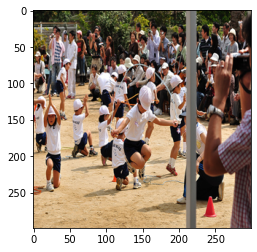

In [65]:
plt.imshow(np.transpose(get_image(my_data_dir, IMG_DIR, dev_list[435]).numpy(), axes=(1, 2, 0))) # change me when running for roscoe
print(image_beam_decoder(word_to_id, id_to_word, image_caption_model, MAX_LEN, device, 1, enc_dev[435]))
print(image_beam_decoder(word_to_id, id_to_word, image_caption_model, MAX_LEN, device, 3, enc_dev[435]))
print(image_beam_decoder(word_to_id, id_to_word, image_caption_model, MAX_LEN, device, 5, enc_dev[435]))
print(image_beam_decoder(word_to_id, id_to_word, image_caption_model, MAX_LEN, device, 10, enc_dev[435]))
print(image_beam_decoder(word_to_id, id_to_word, image_caption_model, MAX_LEN, device, 15, enc_dev[435]))
print(image_beam_decoder(word_to_id, id_to_word, image_caption_model, MAX_LEN, device, 20, enc_dev[435]))


### Nucleus Decoder

**TODO** Now, let's implement another decoder. Rather than selecting the top `n` tokens at each decoding step, we could sample the next word from the distribution (i.e. the softmax activated output) returned by the model. This allows us to incorporate some randomness into the decoding process.  Below, we'll implement a specific sampling-based decoding strategy: nucleus sampling.  

In nucleus sampling \[[Holtzman et al., 2019](https://arxiv.org/abs/1904.09751)\], at each decoding step, we only consider the smallest subset of the vocabulary tokens whose cumulative probability mass reaches a predefined threshold `p` (the "nucleus" of the distribution).  The probability mass of truncated tokens is then redistributed to the selected tokens.  We sample the next word from this re-normalized truncated distribution.  

Implement nucleus sampling below.  To sample from a distribution, consider  [torch.distributions.Categorical](https://pytorch.org/docs/stable/distributions.html). 

In [66]:
# AUTOGRADER TAG: image_nucleus_decoder
def get_probabilities(_caption_model, _enc_image,
                      _input_sequence):
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(_caption_model(
        _enc_image.unsqueeze(0).to(_caption_model.device),
        torch.IntTensor([_input_sequence]).to(
            _caption_model.device)))
    values, indicies = torch.sort(probabilities,
                                  descending=True)
    return values[0], indicies[0]


def get_smallest_subsample(_values, p):
    value_sum = 0
    for index, value in enumerate(_values):
        value_sum += value.cpu().item()
        if value_sum > p:
            return value_sum, index


def get_renormalized_values(values, value_sum):
    return [value[i] / value_sum for i in
            range(0, len(values))]


@noglobal
def image_nucleus_decoder(_word_to_id, _id_to_word,
                          _caption_model, _max_len, _device,
                          p, _enc_image,
                          return_scores=False):
    input_sequence = [_word_to_id['<START>']]
    output = ['<START>']
    seq_prob = 0

    for i in range(0, _max_len):
        values, indicies = get_probabilities(_caption_model,
                                             _enc_image,
                                             input_sequence)
        value_sum, index = get_smallest_subsample(values, p)
        renormalized_values = torch.div(values[:index + 1],
                                        value_sum)  # we get the index back, length is index + 1

        sample_index = torch.distributions.Categorical(
            renormalized_values).sample().item()
        predicted_word = _id_to_word[
            indicies[sample_index].item()]
        seq_prob += math.log(values[sample_index].item())

        input_sequence.append(_word_to_id[predicted_word])
        output.append(predicted_word)

        if predicted_word == '<END>':
            seq_prob = seq_prob / len(output)
            break

    if return_scores:
        return output, seq_prob
    return output


Now, let's see what kind of output we get:

['<START>', 'a', 'crowd', 'swings', 'something', 'in', 'the', 'air', '.', '<END>']
['<START>', 'kids', 'ride', 'makeshift', 'blue', 'and', 'ball', '.', '<END>']
['<START>', 'a', 'man', 'stands', ',', 'two', 'officers', ',', 'an', 'older', 'woman', 'in', 'a', 'white', 'background', '.', '<END>']
['<START>', 'a', 'group', 'of', 'young', 'men', 'wearing', 'white', 'outfits', 'playing', 'a', 'game', '.', '<END>']
['<START>', 'a', 'group', 'of', 'children', 'standing', 'in', 'line', 'of', 'a', 'type', 'sports', 'game', '.', '<END>']


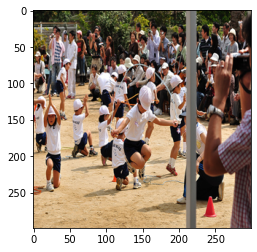

In [67]:
plt.imshow(np.transpose(get_image(my_data_dir, IMG_DIR, dev_list[435]).numpy(), axes=(1, 2, 0))) # change me when running for roscoe  
for i in range(5): 
    print(image_nucleus_decoder(word_to_id, id_to_word, image_caption_model, MAX_LEN, device, 0.95, enc_dev[435]))

## Part V - BLEU and Evaluation

Finally, let's evaluate our trained model on our development set.  A standard evaluation metric in language generation tasks in BLEU.  Please consult the written assignment description for an introduction to BLEU.  While libraries exist that will calculate it for you, for this assignment you'll need to implement it yourself.  We'll use your implementation to evaluate the performance of the various decoding strategies on the development set.

### Calculate BLEU

**TODO** Implement `bleu` below.  Candidate should be a list of words (the generated caption).  References should be a list of lists of words (the gold label captions).  Weights should be our `n`-gram specific weights (and its length should determine the range of `n`-grams to use!)

In [68]:
# AUTOGRADER TAG: bleu

def get_ngrams(seq):
    seq_ngrams = []
    for i in range(1, 5):
        ngram = ngrams(seq, i)
        seq_ngrams.append(
            [' '.join(grams) for grams in ngram])
    return seq_ngrams


def get_ngram_modified_precision_score(ngrams, index,
                                       references_ngrams):
    unique_ngrams = set(ngrams)
    clipping_ngram_counts = []
    for ngram in unique_ngrams:
        count = ngrams.count(ngram)
        max_ref_count = max(
            references_ngrams[i][index].count(ngram) for i
            in
            range(
                len(references_ngrams)))  # get maximum count of a ngram across all references

        clipping_ngram_counts.append(
            min(count, max_ref_count))

    return sum(clipping_ngram_counts) / len(ngrams)


def get_weighted_precision_score(candidate_ngrams,
                                 references_ngrams):
    modified_precision_scores = []
    for index, ngrams in enumerate(candidate_ngrams):
        precision_score = get_ngram_modified_precision_score(
            ngrams, index, references_ngrams)
        if precision_score != 0:
            modified_precision_scores.append(
                precision_score)

    weighted_precision_score = 0
    for i in range(0, len(modified_precision_scores)):
        weighted_precision_score += 1 / len(
            modified_precision_scores) * math.log(
            modified_precision_scores[i])

    return weighted_precision_score


def get_brevity_penalty(_candidate, _references):
    candidate_length = len(_candidate)

    min_diff = math.inf
    for ref in _references:
        if abs(len(ref) - candidate_length) < min_diff:
            reference_length = len(ref)
            min_diff = abs(len(ref) - candidate_length)

    if candidate_length > reference_length:
        return 1
    else:
        return math.exp(
            1 - reference_length / candidate_length)


@noglobal
def bleu(_candidate, _references, _weights):
    references_ngrams = []
    for _ref in _references:
        references_ngrams.append(get_ngrams(_ref))
    candidate_ngrams = get_ngrams(_candidate)

    weighted_precision_score = get_weighted_precision_score(
        candidate_ngrams, references_ngrams)
    brevity_penalty = get_brevity_penalty(_candidate,
                                          _references)

    bleu_score = brevity_penalty * math.exp(
        weighted_precision_score)
    return bleu_score


Now let's evaluate our various decoders.

In [ ]:
def evaluate(decoder):
    bleu_scores = []
    image_caption_model.eval()
    for d_image, d_enc in zip(dev_list, enc_dev):
        bleu_scores.append(bleu(
            decoder(d_enc),
            descriptions[d_image],
            [1 / 4, 1 / 4, 1 / 4, 1 / 4]
        ))
    return np.mean(bleu_scores)


for (name, decoder) in [
    ('greedy',
     partial(image_greedy_decoder, word_to_id, id_to_word,
             image_caption_model, MAX_LEN, device,
             return_scores=False)),
    ('beam-3',
     partial(image_beam_decoder, word_to_id, id_to_word,
             image_caption_model, MAX_LEN, device, 3)),
    ('beam-5',
     partial(image_beam_decoder, word_to_id, id_to_word,
             image_caption_model, MAX_LEN, device, 5)),
    ('nucleus-0.95',
     partial(image_nucleus_decoder, word_to_id, id_to_word,
             image_caption_model, MAX_LEN, device, 0.95,
             return_scores=False))
]:
    print(name, evaluate(decoder))


greedy 0.3362615179936522
beam-3 0.3440730360018863


Feel free to include any additional generations below!